# Demonstrate result using pretrained model

## Load model

In [48]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
import albumentations as A 
import cv2
import json
import os
import shutil
from Data.utils import collate_fn
import zipfile
import matplotlib.pyplot as plt
import numpy as np


load_model = torch.load('model.pt', map_location=torch.device('cpu'))
load_model.eval()

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, 

## Custom dataset

In [49]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root # files directory
        self.transform = transform # applied transformation
        self.demo = demo # set true if we need to keep original and transformed images
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images"))) # images directory
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations"))) # annotations directory
    
    def __getitem__(self, idx):
        # Open requested image 
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
        # Open corresponding annotations
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])
        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
            
            # All bounding boxes are for joint
            bboxes_labels_original = ['Joint' for _ in bboxes_original]            

        # If transformations is specified, we apply it fot this image
        if self.transform:
            # Flatten keypoints array, i.e. 
            # instead of double list create single list of x and y coordinates only for all keypoints
            keypoints_original_flattened = [kp_data[0:2] for keypoint in keypoints_original for kp_data in keypoint]
            
            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            
            # Unflatten keypoints coordinates, i.e. from single list of pairs of x and y coordinates,
            # we need to create double list with such pairs
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,2,2)).tolist()

            # For each unflattened keypoint, add corresponding visibility value from initial data
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened): # Iterating over objects
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
        
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are glue tubes
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)        
        img = F.to_tensor(img)
        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)

## Random transformation to image

In [50]:
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees random number of times
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'),
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels'])
    )

## Coordinates converter

In [51]:
keypoint_names = ['Head', 'Tail']

# For each label the information about bounding box is the most important
# Since we have wrong order of classes inside each label, we need to reconfigure it as well
# We keep head with the same class number while changing the tail class number
upd_classes = {0:0, 2:1}

def converter(file_labels, file_image, keypoint_names):

    img = cv2.imread(file_image)
    img_w, img_h = img.shape[1], img.shape[0] # Image width and height
    
    labels_arr = []
    # Read all labels from file
    with open(file_labels) as f:
        all_labels = f.readlines()
        for label in all_labels:
            label_split = label.split()
            labels_arr.append([int(label_split[0])] + [round(float(el), 5) for el in label_split[1:]])
    
    bboxes = [] # Bounding boxes for joints
    keypoints = [] # Coordinates of keypoints, i.e., heads and tails

    for label in labels_arr:
        # If current label class is 1, it is joint and we need to find corresponding bounding box,
        # i.e., multiply scaled coordinates and dimensions by image widht and height respectively
        # to find coordinates of top left and bottom right corners
        if label[0] == 1:
            x_c, y_c, w, h = round(label[1] * img_w), round(label[2] * img_h), \
                            round(label[3] * img_w), round(label[4] * img_h)
            top_left_x, top_left_y, bottom_right_x, bottom_right_y = round(x_c - w/2), round(y_c - h/2), \
                                                                    round(x_c + w/2), round(y_c + h/2)
            bboxes.append([top_left_x, top_left_y, bottom_right_x, bottom_right_y])

        # Otherwise, just find the real senter of a keypoint and assign updated class number
        else:
            kp_class, x_c, y_c = upd_classes[label[0]], round(label[1] * img_w), round(label[2] * img_h)
            keypoints.append([kp_class, x_c, y_c])

    # For this moment keypoints may be in wrong order and we need to restore it,
    # i.e., for each bounding box we find corresponding keypoints
    keypoints_sorted = [] # list of sorted keypoints
    for bbox_idx, bbox in enumerate(bboxes):
        top_left_x, top_left_y, bottom_right_x, bottom_right_y = bbox[0], bbox[1], \
                                                                  bbox[2], bbox[3] # corners of bounding box
        bbox_keypoints = []
        for kp in keypoints:
            kp_class, kp_x, kp_y = kp[0], kp[1], kp[2] # keypoint class and coordinates
            # If the current keypoint is located inside the bounding box, then it belongs to it, so we save it
            if top_left_x < kp_x < bottom_right_x and top_left_y < kp_y < bottom_right_y:
                bbox_keypoints.extend([[kp_x, kp_y, 1]]) # add keypoint to the current bounding box
                # keypoints have 1 at the end which means they are all visible
        keypoints_sorted.append(bbox_keypoints) # Save keypoints
    return bboxes, keypoints_sorted


## Save to JSON file

In [52]:
def dump2json(bboxes, keypoints_sorted, file_json):
    annotations = {}
    annotations['bboxes'], annotations['keypoints'] = bboxes, keypoints_sorted
    with open(file_json, "w") as f:
        json.dump(annotations, f)

## Load data

In [53]:
IMAGES_TRAIN = 'images/train/images'
LABELS_TRAIN = 'images/train/labels'
ANNOTATIONS_TRAIN = 'images/train/annotations'

IMAGES_TEST = 'images/test/images'
LABELS_TEST = 'images/test/labels'
ANNOTATIONS_TEST = 'images/test/annotations'

# Create directories of not done, otherwise remove them and create empty folders
if not os.path.isdir(ANNOTATIONS_TRAIN):
  os.mkdir(ANNOTATIONS_TRAIN)
else:
  shutil.rmtree(ANNOTATIONS_TRAIN)
  os.mkdir(ANNOTATIONS_TRAIN)
if not os.path.isdir(ANNOTATIONS_TEST):
  os.mkdir(ANNOTATIONS_TEST)
else:
  shutil.rmtree(ANNOTATIONS_TEST)
  os.mkdir(ANNOTATIONS_TEST)


files_names_train = [file.split('.jpg')[0] for file in os.listdir(IMAGES_TRAIN)] # All train images

for file in files_names_train:
    file_labels = os.path.join(LABELS_TRAIN, file + ".txt") # read labels data
    file_image = os.path.join(IMAGES_TRAIN, file + ".jpg") # read image
    bboxes, keypoints_sorted = converter(file_labels, file_image, keypoint_names) # convert coordinates
    dump2json(bboxes, keypoints_sorted, os.path.join(ANNOTATIONS_TRAIN, file + '.json')) # save into JSON file


files_names_test = [file.split('.jpg')[0] for file in os.listdir(IMAGES_TEST)] # All test images

for file in files_names_test:
    file_labels = os.path.join(LABELS_TEST, file + ".txt") # read labels data
    file_image = os.path.join(IMAGES_TEST, file + ".jpg") # read image
    bboxes, keypoints_sorted = converter(file_labels, file_image, keypoint_names) # convert coordinates
    dump2json(bboxes, keypoints_sorted, os.path.join(ANNOTATIONS_TEST, file + '.json')) # save into JSON file

## Create custom datasets

In [54]:
with zipfile.ZipFile('Data/Keypoints.v2i.yolov5pytorch.zip', 'r') as zip_ref:
    zip_ref.extractall('images/')

KEYPOINTS_FOLDER_TRAIN = 'images/train'
KEYPOINTS_FOLDER_TEST = 'images/test'

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=3, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

## Visualize result

In [55]:
keypoints_classes_ids2names = {0: 'Head', 1: 'Tail'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    # Draw rectangle for each bounding box
    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    # Draw circle for each keypoint and write corresponding class
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 3, (255,0,0), -5)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1)

    # If original image is not provided, just show provided image
    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.axis('off')
        plt.imshow(image)

    # Otherwise draw rectangles and circles on original image
    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 3, (255,0,0), -5)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].axis('off')
        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].axis('off')
        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)

## Take image and make prediction

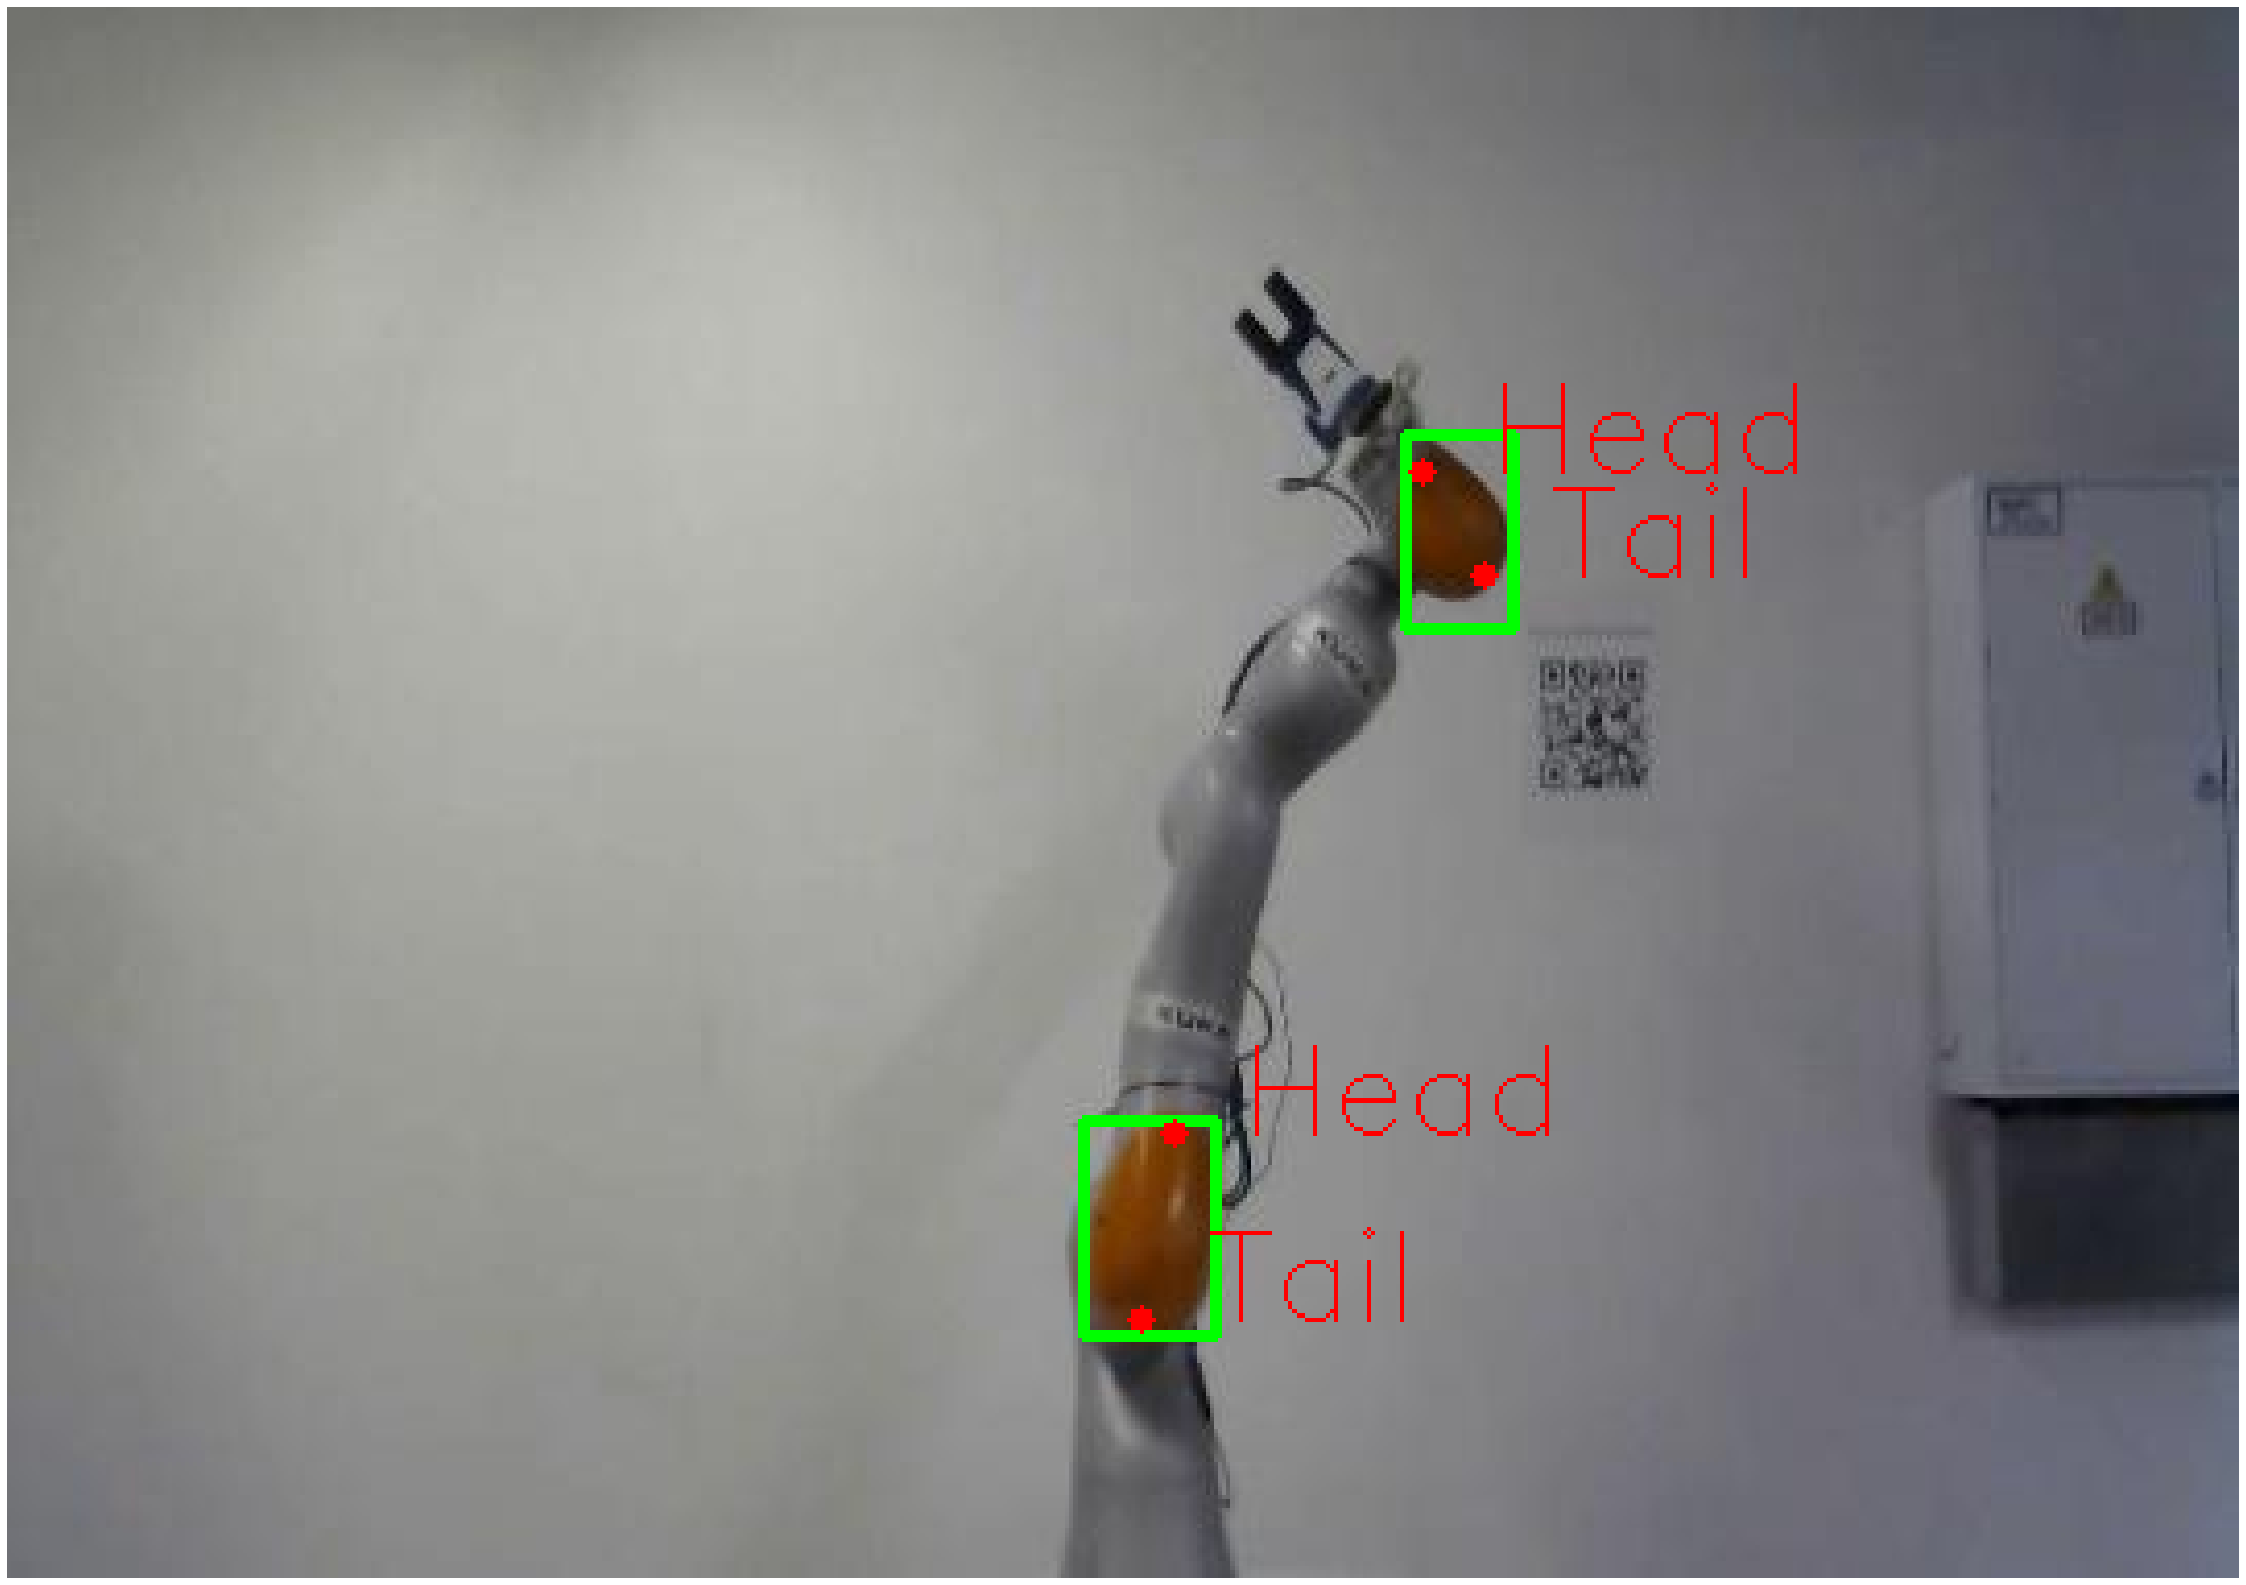

In [56]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Take images from dataset
iterator = iter(data_loader_test)
for _ in range(7):
  images, targets = next(iterator)
images = list(image.to(device) for image in images)

# Generate predictions
with torch.no_grad():
    load_model.to(device)
    load_model.eval()
    output = load_model(images)

# Take one of predicted images
image3 = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
# Get prediction scores
scores = output[0]['scores'].detach().cpu().numpy()

# Find indices of elements with score > 0.2
high_scores_idxs = np.where(scores > 0.2)[0].tolist()
# Find indicess of boxes after applying Non-Maximum Suppression (NMS)
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.1).cpu().numpy()

# Find bounding boxes using thresholed indices
bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))

# Find keypoints using thresholed indices
keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

# Call function to visualize result
visualize(image3, bboxes, keypoints)